In [2383]:
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

### Data generation process

In [2384]:
#Data generation underlying process
def f(x):
    return 4*x**3 + 5*x**2 + 3*x + 0.5

In [2385]:
n_samples = 10 #Training samples

X_train = np.random.uniform(low = 0, high = 1, size = n_samples)
X_train = np.sort(X_train)

epsilon = np.random.normal(loc = 0, scale = 1, size = n_samples)

In [2386]:
X_train

array([0.28191623, 0.32628638, 0.47630075, 0.56407537, 0.69463569,
       0.71229932, 0.74860167, 0.81214195, 0.87181552, 0.95234916])

In [2387]:
#Data generation under additive noise
Y_train = f(X_train) + epsilon

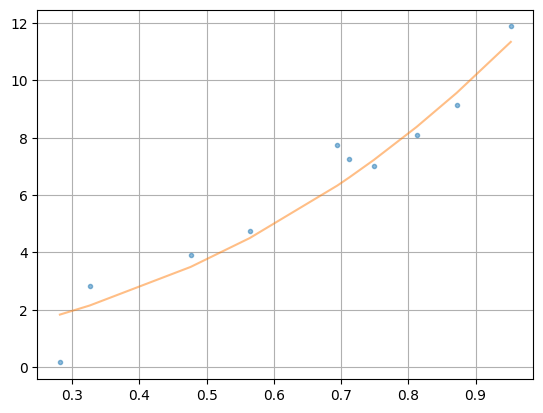

In [2388]:
def plot_process(x_data, y_data, y_generation):
    plt.plot(x_data, y_data, '.', alpha=0.5)
    plt.plot(x_data, y_generation, '-', alpha=0.5)
    plt.grid()
    plt.show()

plot_process(X_train, Y_train, f(X_train))

### Vanilla GP regression

Kernel choice: exponential with parameter 0.5

In [2389]:
#Define kernel
def kernel(x_1, x_2):
    return np.exp(-0.5*np.linalg.norm(x_1 - x_2)**2)

In [2390]:
def build_covariance_from_kernel(X_1, X_2):

    res = np.zeros((len(X_1), len(X_2)))

    for i in range(len(X_1)):
        for j in range(len(X_2)):

            res[i, j] = kernel(X_1[i], X_2[j])

    return res

In [2391]:
X_test = np.random.uniform(low = 0, high = 1, size = 1)
X_test = np.sort(X_test)

In [2392]:
K_train_train = build_covariance_from_kernel(X_train, X_train)
K_train_test = build_covariance_from_kernel(X_train, X_test)
K_test_train = build_covariance_from_kernel(X_test, X_train)
K_test_test = build_covariance_from_kernel(X_test, X_test)

In [2393]:
Sigma = np.diag(np.full(len(K_train_train), 1))

In [2394]:
f_test_mean = np.matmul(np.matmul(K_test_train, np.linalg.inv(K_train_train + Sigma)), Y_train)

In [2395]:
Cov_f_test = K_test_test - np.matmul(np.matmul(K_test_train, np.linalg.inv(K_train_train + Sigma)), K_train_test)

In [2396]:
prediction = np.random.multivariate_normal(f_test_mean, Cov_f_test, size=1)

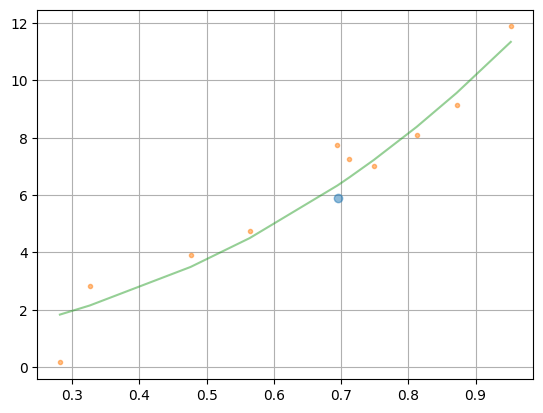

In [2397]:
def plot_prediction_GP(X_train, Y_train, X_test, prediction):
    plt.plot(X_test, prediction, 'o', alpha=0.5)
    plt.plot(X_train, Y_train, '.', alpha=0.5)
    plt.plot(X_train, f(X_train), '-', alpha=0.5)
    plt.grid()
    plt.show()

plot_prediction_GP(X_train, Y_train, X_test, prediction[0])

### Experiment

In [2398]:
def Wasserstein_squared_for_Gaussians(mean_1, cov_1, mean_2, cov_2):

    mean_distance = np.linalg.norm(mean_1 - mean_2)**2

    cross_influence_trace = 2*np.trace(scipy.linalg.sqrtm(np.matmul(np.matmul(scipy.linalg.sqrtm(cov_1), cov_2), scipy.linalg.sqrtm(cov_1))))
    

    return mean_distance + np.trace(cov_1) + np.trace(cov_2) - cross_influence_trace

In [2399]:
def generate_random_covariance_matrix(n):
    return datasets.make_sparse_spd_matrix(dim = n, alpha = 0.5, norm_diag = False)

<Axes: >

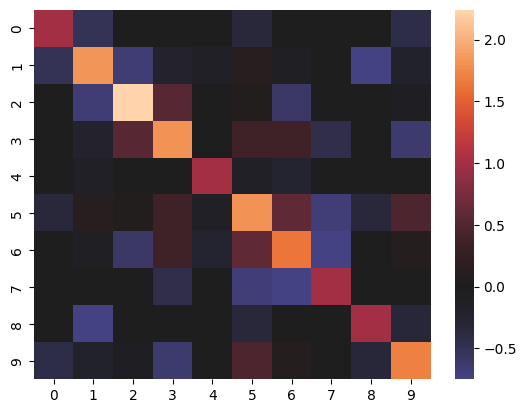

In [2400]:
Sigma = generate_random_covariance_matrix(len(X_train))

sns.heatmap(Sigma, center = 0)

In [2401]:
#MODEL WITH IID NOISE
Sigma_vanilla = np.diag(np.full(len(K_train_train), 1))
f_test_mean_vanilla = np.matmul(np.matmul(K_test_train, np.linalg.inv(K_train_train + Sigma_vanilla)), Y_train)
Cov_f_test_vanilla = K_test_test - np.matmul(np.matmul(K_test_train, np.linalg.inv(K_train_train + Sigma_vanilla)), K_train_test)

<Axes: >

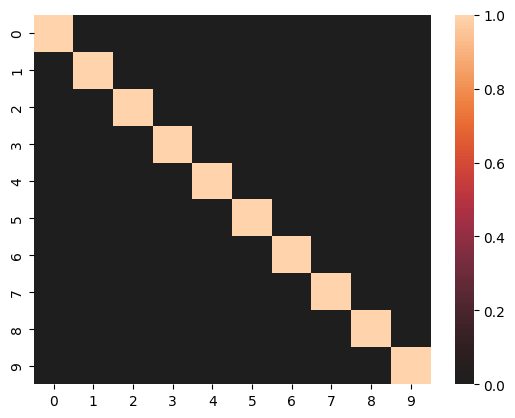

In [2402]:
sns.heatmap(Sigma_vanilla, center = 0)

In [2403]:
def run_covariance_simulations(n_simulations, distance_noise_parameter):

    n_simulations = n_simulations

    history_distance_noise, history_distance_posteriors = [], []
    for i in range(n_simulations):

        Sigma = generate_random_covariance_matrix(len(X_train))

        distance_noise = Wasserstein_squared_for_Gaussians(np.zeros(n_samples), Sigma_vanilla, np.zeros(n_samples), Sigma)

        if(distance_noise < distance_noise_parameter):

            f_test_mean = np.matmul(np.matmul(K_test_train, np.linalg.inv(K_train_train + Sigma)), Y_train)
            Cov_f_test = K_test_test - np.matmul(np.matmul(K_test_train, np.linalg.inv(K_train_train + Sigma)), K_train_test)

            distance_posteriors = Wasserstein_squared_for_Gaussians(f_test_mean_vanilla, Cov_f_test_vanilla, f_test_mean, Cov_f_test)

            history_distance_noise.append(distance_noise)
            history_distance_posteriors.append(np.real(distance_posteriors))

    return history_distance_noise, history_distance_posteriors

In [2404]:
history_distance_noise, history_distance_posteriors = run_covariance_simulations(n_simulations = 10000, distance_noise_parameter = 50)

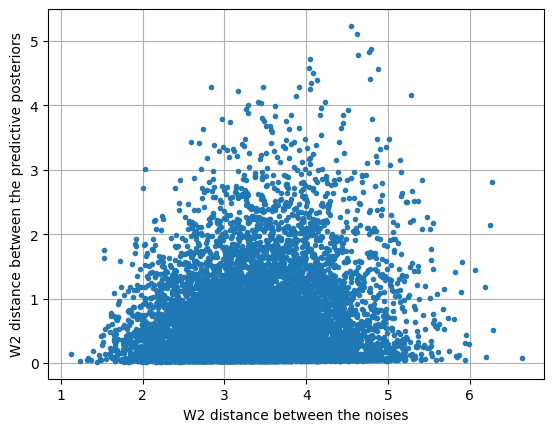

In [2405]:
def plot_distance_histories(history_distance_noise, history_distance_posteriors): 
    plt.plot(history_distance_noise, history_distance_posteriors, '.', alpha=0.95)
    plt.xlabel('W2 distance between the noises')
    plt.ylabel('W2 distance between the predictive posteriors')
    plt.grid()
    plt.show()

plot_distance_histories(history_distance_noise, history_distance_posteriors)

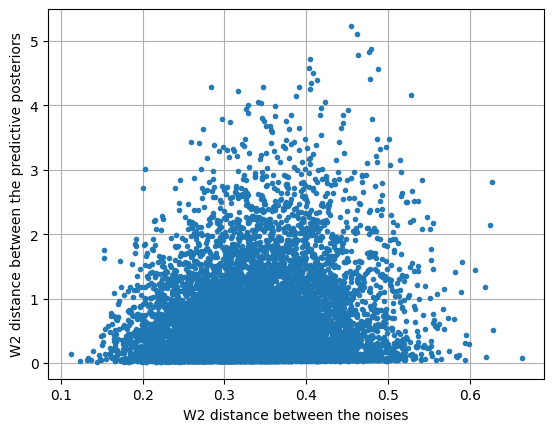

In [2406]:
plot_distance_histories([x / len(X_train) for x in history_distance_noise], history_distance_posteriors)

### Observations


- The W2 distance between the noises increases with the size of training data (i.e. with the size of the matrix K_train_train)

